# Import package

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
%matplotlib inline
from qqdm.notebook import qqdm,format_str
import random
import numpy as np

##  Load test data

In [2]:
# X=np.load('./data_X1000.npy')
# #draw 
# v=np.arange(0,200,0.2)
# plt.plot(v,X[1111])

## Load real data

In [3]:
X1=np.load('data_nomal_0-50.npy')
X2=np.load('data_nomal_50-100.npy')
X_1=X1.reshape(-1,30000)
X_2=X2.reshape(-1,30000)
X=np.vstack((X_1,X_2))

In [4]:
# v=np.arange(0,300,0.01)
# plt.plot(v,X[1])

## VAE

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD    


class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1)
#         self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
#         self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
#         self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
#         x = F.leaky_relu(self.fc1(x), 0.2)
#         x = F.dropout(x, 0.3)
#         x = F.leaky_relu(self.fc2(x), 0.2)
#         x = F.dropout(x, 0.3)
#         x = F.leaky_relu(self.fc3(x), 0.2)
#         x = F.dropout(x, 0.3)
#         return torch.sigmoid(self.fc4(x))
        return torch.sigmoid(self.fc1(x))


In [6]:
# build or load model 
vae=torch.load('model_vae.pt')
# vae = VAE(x_dim=30000, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [7]:
optimizer = optim.Adam(vae.parameters())
bs = 8
num_epochs=50
train_loader = torch.utils.data.DataLoader(dataset=X, batch_size=bs, shuffle=True)

# Training

In [8]:
for epoch in range(1, num_epochs+1):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.float().cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

/home/ni/anaconda3/envs/pytorchdst/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/5600 (0%)]	Loss: 335.927490
Train Epoch: 1 [800/5600 (14%)]	Loss: 1101.716797
Train Epoch: 1 [1600/5600 (29%)]	Loss: 1785.648560
Train Epoch: 1 [2400/5600 (43%)]	Loss: 1154.173950
Train Epoch: 1 [3200/5600 (57%)]	Loss: 2013.181274
Train Epoch: 1 [4000/5600 (71%)]	Loss: 1327.434448
Train Epoch: 1 [4800/5600 (86%)]	Loss: 1330.348999
====> Epoch: 1 Average loss: 1124.5686
Train Epoch: 2 [0/5600 (0%)]	Loss: 1005.915039
Train Epoch: 2 [800/5600 (14%)]	Loss: 1431.530151
Train Epoch: 2 [1600/5600 (29%)]	Loss: 1030.038330
Train Epoch: 2 [2400/5600 (43%)]	Loss: 2401.628418
Train Epoch: 2 [3200/5600 (57%)]	Loss: 353.533997
Train Epoch: 2 [4000/5600 (71%)]	Loss: 1218.118164
Train Epoch: 2 [4800/5600 (86%)]	Loss: 988.408447
====> Epoch: 2 Average loss: 1121.7827
Train Epoch: 3 [0/5600 (0%)]	Loss: 425.117157
Train Epoch: 3 [800/5600 (14%)]	Loss: 594.429260
Train Epoch: 3 [1600/5600 (29%)]	Loss: 1313.273804
Train Epoch: 3 [2400/5600 (43%)]	Loss: 734.920715
Train Epoch: 3 [3200/5600

In [9]:
# torch.save(vae, 'model_vae.pt')

In [12]:
num_epochs=10
D=Discriminator(30000).cuda()
n_critic = 2
clip_value = 0.01
z_dim=2
ckpt_dir = 'checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)
opt_G = torch.optim.Adam([param for name, param in vae.named_parameters() if 'fc1' not in name and'fc2' not in name and 'fc3' not in name])
opt_D = torch.optim.Adam(D.parameters())

In [13]:
D

Discriminator(
  (fc1): Linear(in_features=30000, out_features=1, bias=True)
)

In [14]:
vae.train()
D.train()
steps = 0
for e, epoch in enumerate(range(num_epochs)):
    progress_bar = qqdm(train_loader)
    for i, data in enumerate(progress_bar):
        wave = data.float().cuda()
        bs = wave.size(0)
        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_wave = Variable(wave).cuda()
        f_wave = vae.decoder(z)

#         WGAN Loss
        loss_D = -torch.mean(D(r_wave)) + torch.mean(D(f_wave))
       

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake example.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_wave = vae.decoder(z)

            # Model forwarding
            f_logit = D(f_wave)
            
            # WGAN Loss
            loss_G = -torch.mean(D(f_wave))

            # Model backwarding
            vae.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })


  Iters     Elapsed Time       Speed     Loss_D   Loss_G  Epoch  Step           
 700/700  00:00:01<00:00:00  363.41it/s  -0.0219  -0.437    1    700            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  365.87it/s  -0.2213  -0.3344    2    1400          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  365.69it/s  -0.0193  -0.6131    3    2100          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  365.81it/s  -0.1456  -0.3127    4    2800          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D  Loss_G   Epoch  Step           
 700/700  00:00:01<00:00:00  366.26it/s  0.0215  -0.6851    5    3500           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  371.30it/s  -0.0213  -0.3644    6    4200          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  369.60it/s  -0.0666  -0.6309    7    4900          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D   Loss_G   Epoch  Step          
 700/700  00:00:01<00:00:00  368.56it/s  -0.1048  -0.5025    8    5600          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D  Loss_G   Epoch  Step           
 700/700  00:00:01<00:00:00  369.36it/s  0.0277  -0.3897    9    6300           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

  Iters     Elapsed Time       Speed     Loss_D  Loss_G   Epoch  Step           
 700/700  00:00:01<00:00:00  368.87it/s  -0.028  -0.3803   10    7000           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

# Visualize

In [15]:
#draw distribution
def draw_sample(num=12,z_dim=2):
    z = Variable(torch.randn(num, z_dim)).cuda()
    f=vae.decoder(z)
    v=np.linspace(0,200,30000)
    for i,d in enumerate(f):
        a=d.cpu()
        a=a.detach().numpy()
        if i <100 :
                fig, ax = plt.subplots()
                ax.plot(v,a)
#autoencoder input=>recon
def recon(X,num=1):
    x=torch.from_numpy(X)
    ii=x[num].float().cuda()
    output=vae(ii)
    a=output[0].cpu()
    a=a.detach().numpy()
    v=np.linspace(0,100,30000)
    fig, ax = plt.subplots()
    ax.plot(v,X[num])
    fig, ax = plt.subplots()
    ax.plot(v,a)

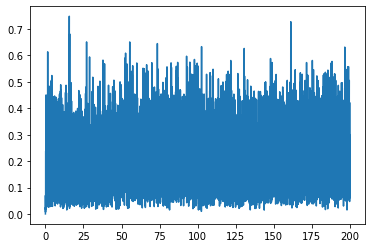

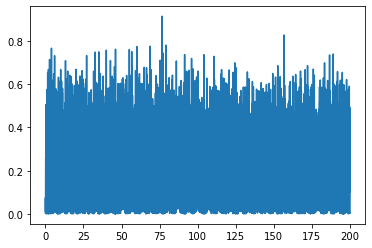

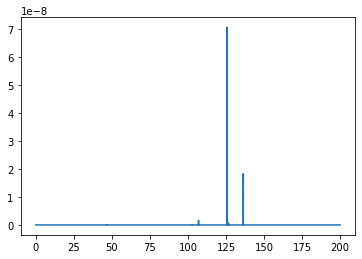

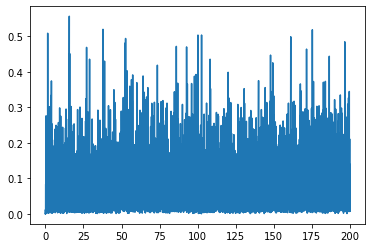

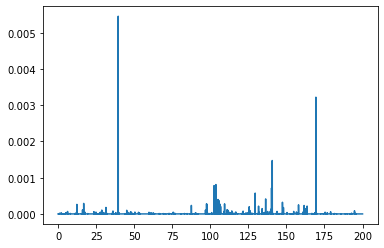

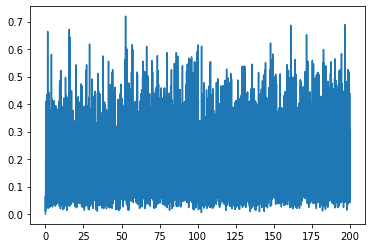

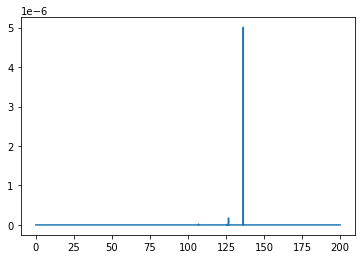

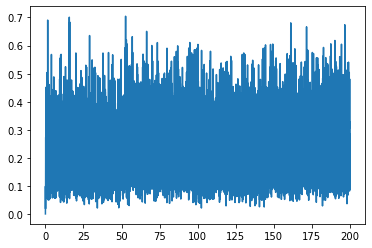

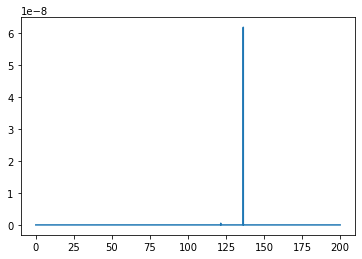

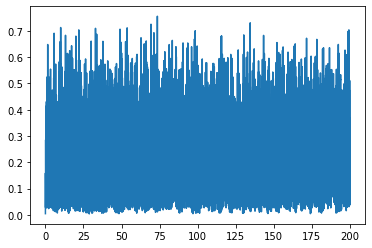

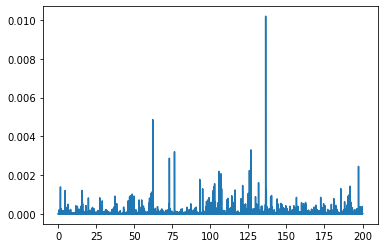

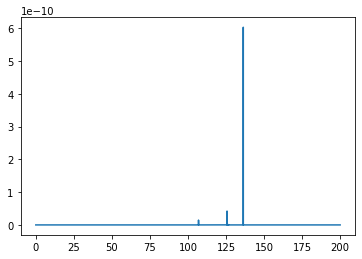

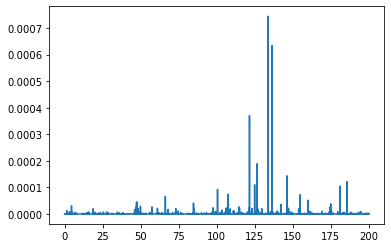

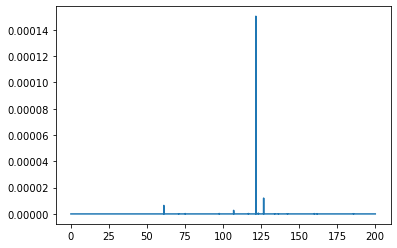

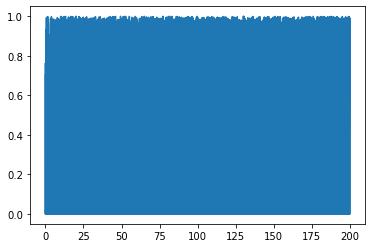

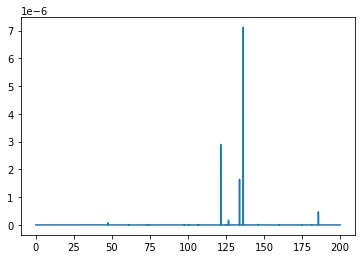

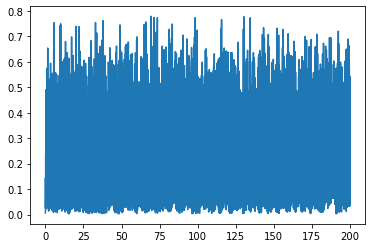

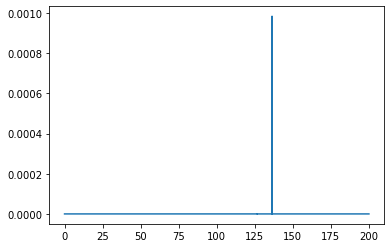

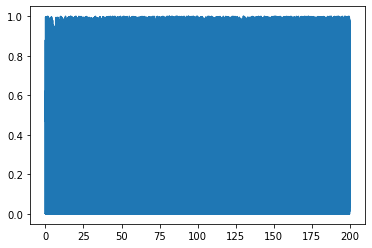

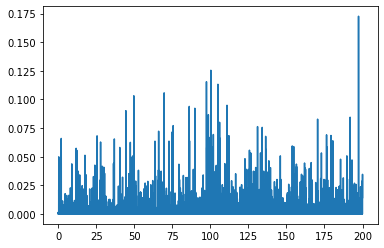

In [16]:
draw_sample(20)

## recon

In [17]:
# x_recon=x*(np.max(X)-np.min(X))+np.min(X)